## Transformações dos dados (colocar dentro da pipeline)

In [26]:
import sys
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp,chi2_contingency
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder, StandardScaler,FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
sys.path.append(r"C:\Users\edude\OneDrive\Área de Trabalho\Códigos\Faculdade\6_Periodo\Aprendizado_superv\Trabalho_aprendizado_super")
from utils.classes import FeatureBuilder

In [2]:
dados = pd.read_csv(r'C:\Users\edude\OneDrive\Área de Trabalho\Códigos\Faculdade\6_Periodo\Aprendizado_superv\Trabalho_aprendizado_super\data\gold\dados_finais_gold.csv')

### Etapas:

- Separação treino e teste
    - Validação da separação dos dados

- Pipeline de transformação e criação de variaveis

- Modelos 

- Avaliação dos modelos

- Estudos de threshold 

- Feature importance, outras análises

#### Treino e Teste

In [17]:
x = dados.drop(columns=['responded'])
y = dados['responded']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
num_cols = x_train.select_dtypes(include=[np.number]).columns

resultados_num = []
for col in num_cols:
    stat, p = ks_2samp(x_train[col], x_test[col])
    resultados_num.append({"variavel": col,"media_train": x_train[col].mean(),"media_test": x_test[col].mean(),"p_ks": p})
    
resultados_num = pd.DataFrame(resultados_num).sort_values("p_ks")

resultados_num

,variavel,media_train,media_test,p_ks
7,social,0.602311,0.588403,0.039408
8,web,0.796899,0.809528,0.078462
2,reward_offer,4.216097,4.166772,0.617592
4,duration,6.500158,6.523463,0.686574
9,time_total,398.293225,399.597251,0.746080
0,age,62.491013,62.346500,0.756489
10,valor_total,10.656312,11.121661,0.983873
11,valor_total_log,1.325131,1.324559,0.983873
3,difficulty,7.709086,7.721520,0.999996
5,email,1.000000,1.000000,1.000000


<Figure size 600x400 with 0 Axes>

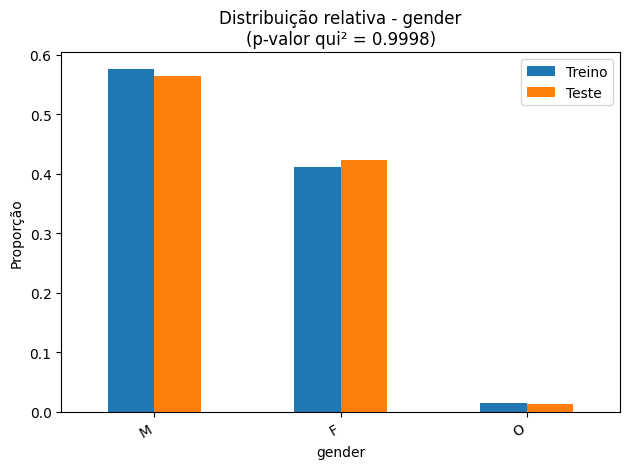

<Figure size 600x400 with 0 Axes>

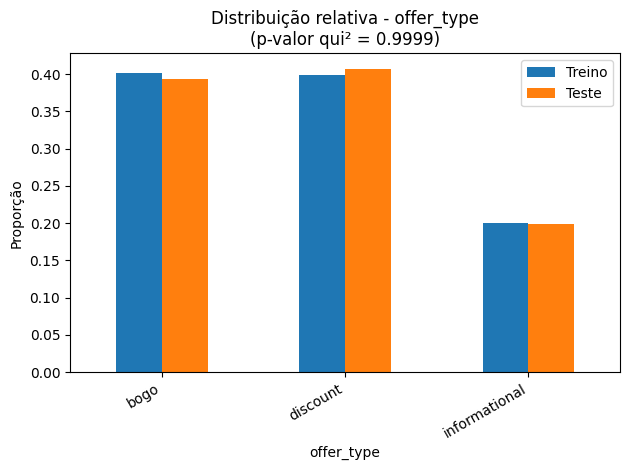

,variavel,p_chi2
0,gender,0.999830
1,offer_type,0.999908


In [23]:
cat_cols = x_train.select_dtypes(exclude=[np.number]).columns
cat_cols = cat_cols.drop(['offer_id','person','became_member_on'], errors='ignore') 
resultados_cat = []
for col in cat_cols:
    tabela = pd.crosstab(x_train[col], x_test[col])
    dist_train = x_train[col].value_counts(normalize=True)
    dist_test = x_test[col].value_counts(normalize=True)
    all_idx = dist_train.index.union(dist_test.index)
    dist_train = dist_train.reindex(all_idx, fill_value=0)
    dist_test = dist_test.reindex(all_idx, fill_value=0)
    chi2, p, dof, _ = chi2_contingency([dist_train, dist_test])
    resultados_cat.append({
        "variavel": col,
        "p_chi2": p
    })

    plt.figure(figsize=(6,4))
    df_plot = pd.DataFrame({
        "Treino": dist_train,
        "Teste": dist_test
    })
    df_plot.plot(kind="bar")
    plt.title(f"Distribuição relativa - {col}\n(p-valor qui² = {p:.4f})")
    plt.ylabel("Proporção")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


resultados_cat = pd.DataFrame(resultados_cat).sort_values("p_chi2")
resultados_cat


In [28]:
dados_id = ['person', 'offer_id']

feature_pipeline = Pipeline( steps=[
    ('feature_engineering', FeatureBuilder(map_gender=True, drop_raw=True, max_age=100))
])

numeric_transformer = Pipeline(steps=[
    ('inputer_num', SimpleImputer(strategy='median'))
])
categorical_transformer = Pipeline(steps=[
    ('inputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('enconder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

num_sel = lambda X: X.select_dtypes(include=np.number).columns.difference(dados_id)
cat_sel = lambda X: X.select_dtypes(exclude=np.number).columns.difference(dados_id)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_sel),
        ('cat', categorical_transformer, cat_sel),
        ('drop_ids', 'drop', dados_id)
    ],
    remainder='drop'
)

prep_pipe = Pipeline(steps=[
    ('fe', feature_pipeline),
    ('pre', preprocessor)
])


## Rascunho

In [ ]:
df_encoded = pd.get_dummies(data, columns=['event','offer_type'],dtype=int)
data['gender'] = data['gender'].map({'female': 0, 'male': 1})
df_profile_clean['age'] = df_profile_clean['age'].replace(118, np.nan)
df_transcript_clean['time_days'] = (df_transcript_clean['time'] / 24).astype(float)

In [ ]:
dados_transacao_agrupado = (
    data
    .groupby(['person', 'offer_id'])['event']
    .unique()
    .reset_index()
)

In [ ]:
dados_transacao_agrupado = (
    data
    .groupby(['person', 'offer_id'])['event']
    .unique()
    .reset_index()
)
dados_transacao_agrupado

,person,offer_id,event
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer completed]"
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]"
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,"[offer received, offer viewed]"
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,"[offer received, offer completed, offer viewed]"
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,"[offer received, offer completed, offer viewed]"
...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,"[offer received, offer viewed, offer completed]"
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[offer received, offer viewed, offer completed]"
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed, offer completed]"
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[offer received, offer completed, offer viewed]"


In [ ]:
data[data['person']=='9fa9ae8f57894cc9a3b8a9bbe0fc1b2f']

,person,event,time,amount,offer_id,reward,gender,age,became_member_on,income,reward_offer,difficulty,duration,offer_type,email,mobile,social,web
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,34.56,2906b810c7d4411798c6938adc9daaa5,2.0,M,42,2016-01-17,96000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
74773,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,354,18.42,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,M,42,2016-01-17,96000.0,3.0,7.0,7.0,discount,1.0,1.0,1.0,1.0
110135,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,474,21.13,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,M,42,2016-01-17,96000.0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
136494,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,540,24.30,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,M,42,2016-01-17,96000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# ============================================================
# 1) Preparar variável-alvo (exemplo: se cliente completou uma oferta)
# ------------------------------------------------------------
# Vamos criar uma variável binária: 1 se houve pelo menos um "offer_completed",
# 0 caso contrário.
clientes_completaram = master.groupby("person")['event'].apply(
    lambda x: int('offer_completed' in x.values)
).reset_index().rename(columns={'event':'completed_offer'})

# Junta essa informação com perfil (onde está o 'income')
df_model = clientes_completaram.merge(df_profile_clean, left_on="person", right_on="id", how="left")

# ============================================================
# 2) Duas versões do dataset
# ------------------------------------------------------------
# a) Versão sem imputação (descarta missing em income)
df_sem_imputacao = df_model.dropna(subset=['income']).copy()

# b) Versão com imputação (substitui missing em income pela mediana)
df_com_imputacao = df_model.copy()
mediana_income = df_com_imputacao['income'].median()
df_com_imputacao['income'] = df_com_imputacao['income'].fillna(mediana_income)

# ============================================================
# 3) Definir X (features) e y (target)
# ------------------------------------------------------------
features = ['age', 'income']   # podemos usar outras, mas income é o foco
target = 'completed_offer'

X1, y1 = df_sem_imputacao[features], df_sem_imputacao[target]
X2, y2 = df_com_imputacao[features], df_com_imputacao[target]

# ============================================================
# 4) Classificador e Validação Cruzada
# ------------------------------------------------------------
clf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Sem imputação
scores_sem = cross_val_score(clf, X1, y1, cv=cv, scoring='accuracy')

# Com imputação
scores_com = cross_val_score(clf, X2, y2, cv=cv, scoring='accuracy')

# ============================================================
# 5) Resultados
# ------------------------------------------------------------
print("Validação Cruzada (sem imputação):")
print("Acurácias:", scores_sem)
print("Média:", scores_sem.mean())

print("\nValidação Cruzada (com imputação pela mediana):")
print("Acurácias:", scores_com)
print("Média:", scores_com.mean())


Validação Cruzada (sem imputação):
Acurácias: [0.75143339 0.75177066 0.75379427 0.753457   0.75143339]
Média: 0.7523777403035413

Validação Cruzada (com imputação pela mediana):
Acurácias: [0.74911765 0.73794118 0.73470588 0.74029412 0.73764706]
Média: 0.7399411764705882


<!-- # Validação Cruzada — Imputação de Renda (income)

## O que foi feito

1) **Definimos a variável-alvo (target)**  
   - Para cada cliente (`person`), marcamos `1` se ele **completou ao menos uma oferta** (`offer_completed`) e `0` caso contrário.  
   - Isso transforma o problema em **classificação binária** (completou vs. não completou).

2) **Juntamos o alvo com o perfil do cliente**  
   - Cruzamos com `df_profile_clean` para ter as features **`age`** e **`income`** (renda).

3) **Criamos duas versões do dataset** para testar o *tratamento de valores ausentes*:
   - **Sem imputação**: removemos linhas onde `income` era nulo (`NaN`).  
   - **Com imputação**: preenchemos `income` faltante com a **mediana** da renda.

4) **Treinamos e avaliamos um modelo igual nos dois cenários**  
   - Modelo: **RandomForestClassifier** (padrão, `random_state=42`).  
   - Validação: **5-fold Stratified Cross-Validation** (mantém a proporção de classes em cada dobra).  
   - Métrica: **accuracy** (acertos/total) em cada dobra; depois calculamos a **média**.

---

## Resultados

- **Sem imputação (descartando NaN)**  
  Acurácias por dobra: `[0.7514, 0.7518, 0.7538, 0.7535, 0.7514]`  
  **Média:** **0.7524**

- **Com imputação (mediana)**  
  Acurácias por dobra: `[0.7491, 0.7379, 0.7347, 0.7403, 0.7376]`  
  **Média:** **0.7399**

---

- A **validação cruzada** estima o desempenho **fora da amostra** (generalização) e reduz o risco de avaliar o modelo apenas em um único “corte” dos dados.
- O modelo **sem imputação** teve **accuracy médio ~1,25 p.p. maior** (*0,7524 vs 0,7399*).  
- Como o **modelo** e a **validação** foram idênticos nos dois cenários, a diferença se deve ao **tratamento de valores ausentes em `income`**.

---

## Conclusão 

- **Para este alvo e esse conjunto de features**, **descartar** as linhas sem `income` rendeu melhor desempenho do que **imputar por mediana**.  
- Possíveis razões:
  - As ausências de `income` **não são aleatórias** (o que a mediana não captura), introduzindo ruído.  
  - Preencher com um valor “típico” (mediana) **achata diferenças** entre clientes e reduz o sinal preditivo.

**Decisão prática:** para esta tarefa, **manter a versão sem imputação de `income`** foi **ligeiramente melhor**.  
(Anote no relatório que você testou os dois tratamentos e comparou com validação cruzada.)

--- -->

